In [ ]:
#check gpu
!nvidia-smi

#<font size = 5><font color = pink> **Cài đặt các module cần thiết và clone code từ Github**

Đầu tiên, nhóm setup môi trường và cài đặt một số module cần thiết để thực hiện model.

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install ninja yacs cython matplotlib tqdm opencv-python shapely scipy tensorboardX pyclipper Polygon3 weighted-levenshtein editdistance

# Install Detectron2
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 18 kB/s 
     |████████████████████████████████| 12.7 MB 156 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.0+cu101 which is incompatible.
     |████████████████████████████████| 108 kB 7.5 MB/s 
     |████████████████████████████████| 124 kB 62.4 MB/s 
     |████████████████████████████████| 123 kB 73.5 MB/s 
     |████████

Tiếp theo, clone code từ repo [AlaiDet](https://github.com/bt-ngo/AdelaiDet) của nhóm. Repo này được fork từ repo gốc của tác giả. Nhóm sẽ sử dụng repo này để thực hiện huấn luyện mô hình ABCNet mà nhóm đã chọn, cũng như dự đoán kết quả của mô hình trên tập test. Trong repo này, nhóm đã thực hiện một số thay đổi như sau:
* Thêm các file config cho custom dataset tại ```configs/BAText/CustomText/```
* Thay đổi ```_C.MODEL.BATEXT.VOC_SIZE = 230``` để bao gồm các ký tự tiếng Việt thay vì ```_C.MODEL.BATEXT.VOC_SIZE = 96``` ở repo gốc tại ```adet/configs/defaults.py```
* Đăng ký (register) custom dataset với tên dataset là ```"train"``` tại ```adet/data/builtin.py```
* Thêm các file để tạo file json từ dataset của cuộc thi cho quá trình huấn luyện của ABCNet tại ```datasets``` (cụ thể là hai file ```classes.txt``` và ```generate_abcnet_json.py```)
* Thay đổi file ```demo/demo.py``` để tạo ra file txt submission cho cuộc thi
* Thay đổi file ```adet/utils/visualizer.py``` để visualize các ký tự tiếng Việt khi dự đoán

In [ ]:
!git clone https://github.com/bt-ngo/AdelaiDet.git
%cd AdelaiDet
!python setup.py build develop

Cloning into 'AdelaiDet'...
remote: Enumerating objects: 2113, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 2113 (delta 68), reused 87 (delta 43), pack-reused 1957
Receiving objects: 100% (2113/2113), 576.36 KiB | 2.28 MiB/s, done.
Resolving deltas: 100% (1279/1279), done.
/content/AdelaiDet
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/adet
copying adet/__init__.py -> build/lib.linux-x86_64-3.7/adet
creating build/lib.linux-x86_64-3.7/adet/modeling
copying adet/modeling/poolers.py -> build/lib.linux-x86_64-3.7/adet/modeling
copying adet/modeling/one_stage_detector.py -> build/lib.linux-x86_64-3.7/adet/modeling
copying adet/modeling/__init__.py -> build/lib.linux-x86_64-3.7/adet/modeling
creating build/lib.linux-x86_64-3.7/adet/checkpoint
copying adet/checkpoint/adet_checkpoint.py -> build/lib.linux-x86_64-3.7/adet/checkpoint
copying adet/che

#<font size = 5><font color = pink> **Xử lý data cho quá trình huấn luyện**

## <font size = 4><font color = pink> **1. Clean data**

Đầu tiên, nhóm đã xem qua bộ dataset mà cuộc thi cung cấp và nhận thấy có khá nhiều nhiễu trong data, có thể kể đến như:
* Các nhãn chỉ có vị trí bounding box, không có nhãn chữ (khuyết phần tử text cuối cùng)
* Các ảnh không có chữ nhưng có nhãn
* Các nhãn có nhãn chữ được thêm số ở phía sau
* Các nhãn có các vị trí bounding box không được xếp theo kim đồng hồ
* Một số chữ có trong ảnh nhưng không được gán nhãn
* Một số chữ trong ảnh bị gán nhãn trùng (có hai bounding box cho một chữ)

Vì vậy, nhóm đã sử dụng công cụ [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) để thực hiện kiểm tra và xử lý data, cụ thể như sau:
* Loại bỏ các nhãn khuyết text và các ảnh không có chữ
* Chỉnh sửa các bounding box theo chiều kim đồng hồ
* Xóa các số được thêm sau chữ và các nhãn trùng
* Gán nhãn các chữ có trong ảnh mà chưa có trong file label \\

Kết quả: bộ dataset đã được xử lý gồm 997 ảnh tại [đây](https://drive.google.com/file/d/1cLBL6FVOt5OAEGV2yupkf-aDsPGP9o2-/view?usp=sharing).

## <font size = 4><font color = pink> **2. Tạo file json cho quá trình huấn luyện mô hình**

**(TL;DR)** Bộ dataset có file json tại [đây](https://drive.google.com/file/d/1Vke9t85lBYosnBCzBnbnHzAizEkCY3V9/view?usp=sharing). Có thể bỏ qua bước này và sử dụng bộ dataset nhóm đã tạo để huấn luyện mô hình. Lưu ý: phải download và unzip file tại folder ```datasets/```. 

In [ ]:
# #download json dataset
# %cd datasets/
# !gdown --id 1Vke9t85lBYosnBCzBnbnHzAizEkCY3V9- -O train.zip
# !unzip train.zip
# !rm train.zip

Để huấn luyện mô hình, cần phải có một file json chứa nhãn thay vì các file txt mà cuộc thi cung cấp. Vì vậy, nhóm đã thêm file code ```generate_abcnet_json.py``` nhằm tạo ra file json này. 

Đầu tiên, chuyển đến folder ```datasets/``` và download bộ dataset mà nhóm đã xử lý ở bước _Clean data_.

In [ ]:
%cd datasets/

/content/AdelaiDet/datasets


In [ ]:
!gdown --id 1cLBL6FVOt5OAEGV2yupkf-aDsPGP9o2- -O train.zip
!unzip train.zip
!rm train.zip

Downloading...
From: https://drive.google.com/uc?id=1cLBL6FVOt5OAEGV2yupkf-aDsPGP9o2-
To: /content/train.zip
538MB [00:03, 139MB/s]
Archive:  train.zip
   creating: train/
   creating: train/images/
  inflating: train/images/train_0001.jpg  
  inflating: train/images/train_0002.jpg  
  inflating: train/images/train_0005.jpg  
  inflating: train/images/train_0006.jpg  
  inflating: train/images/train_0007.jpg  
  inflating: train/images/train_0008.jpg  
  inflating: train/images/train_0010.jpg  
  inflating: train/images/train_0011.jpg  
  inflating: train/images/train_0012.jpg  
  inflating: train/images/train_0014.jpg  
  inflating: train/images/train_0015.jpg  
  inflating: train/images/train_0016.jpg  
  inflating: train/images/train_0018.jpg  
  inflating: train/images/train_0020.jpg  
  inflating: train/images/train_0021.jpg  
  inflating: train/images/train_0022.jpg  
  inflating: train/images/train_0023.jpg  
  inflating: train/images/train_0024.jpg  
  inflating: train/images/t

Tiếp theo, chạy file ```generate_abcnet_json.py``` để tạo file json. Kết quả là một file ```annotations/train.json``` tại folder dataset ```train``` đã download ở bước trên.

In [ ]:
!python generate_abcnet_json.py

Streaming output truncated to the last 5000 lines.
rec VÀ
rec ĐÀO
rec TẠO
Processing: train_0952
rec KATINAT
rec ĐƯỜNG
rec ĐƯỜNG
rec KHỞI
rec BƯỞI
rec MẠC
rec THỊ
rec ĐỒNG
Processing: train_0953
rec Phòng
rec +
rec Hơn
rec HÀ
rec NAM
rec cả
rec khám
rec một
Processing: train_0954
rec TRONG
rec ĐẢM
rec GIỮ
rec O
rec XE
rec CAFE
rec /
rec KHA
rec GI
rec 132
rec 24
rec 140.82
rec NHÀ
rec 24
rec BẢO
Processing: train_0955
rec QUẬN
rec GIÁO
rec 0839102544
rec HOA
rec Quận
rec Nguyễn
rec 1
rec Điện
rec Bến
rec BAN
rec 0839111501
rec 1
rec Phường
rec LƯ
rec Bỉnh
rec TẠO
rec NHÂN
rec Địa
rec O
rec NON
rec NE
rec thoại:
rec chỉ:
rec 01
rec VÀ
rec AS
rec MẦM
rec DÂN
rec DỤC
rec TRƯỜNG
rec ỦY
rec 123
rec PHÒNG
rec ĐÀO
rec 
rec Nghé
rec RE
Processing: train_0956
rec VĂN
rec APP
rec ĐIỂM
rec ANDROID
rec Google
rec ĐIỂM
rec 1000
rec ỦY
rec TÍCH
rec HÓA
rec on
rec ook
rec H
rec Download
rec 1234567890
rec A
rec SỰ
rec MIỄN
rec 1
rec ON
rec Store
rec %
rec VinMart
rec RAU
rec ĐIỂM
rec PHONG
rec C
rec 

#<font size = 5><font color = pink> **Huấn luyện mô hình**

Mô hình mà nhóm chọn để huấn luyện là mô hình ABCNet. Mô hình có backbone là Resnet50-FPN. Một điểm mới của mô hình đó là phương pháp BezierAlign, được mở rộng từ ROIAlign, giúp các bounding box được fit hơn với chữ (đặc biệt là chữ cong - curve text) và từ đó cho kết quả detection tốt hơn. Đồng thời, vì recognition branch (nhận diện chữ) và detection branch (nhận diện vị trí của chữ) của mô hình được train cùng nhau, recognition branch có thể được cải thiện nhờ BezierAlign.

ABCNet sử dụng 8 control point như hình dưới, thay vì 4 control point như dataset mà cuộc thi cung cấp. Vì vậy, nhóm thực hiện interpolate hai điểm U2, U3 và B2, B3 từ 4 control point trong dataset đồng thời trong lúc tạo file json ở script ```generate_abcnet_json.py```

![](https://user-images.githubusercontent.com/34134635/126025170-6e41d083-08fb-4af6-a651-401164157eec.png)|

Nhóm sử dụng mô hình pretrained trên dataset TotalText mà tác giả cung cấp. Lý do nhóm chọn mô hình này thay vì mô hình pretrained trên dataset CTW5000 là vì CTW5000 chỉ cung cấp line level detection của text, trong khi đó bài toán cần word level detection. Vì vậy, mô hình pretrained trên TotalText phù hợp hơn.

Đầu tiên, download mô hình pretrained trên dataset TotalText tác giả cung cấp.

In [ ]:
%cd ..

/content/AdelaiDet


In [ ]:
#download pretrain model
!wget -O tt_attn_R_50.pth https://cloudstor.aarnet.edu.au/plus/s/tYsnegjTs13MwwK/download

--2021-08-13 12:28:05--  https://cloudstor.aarnet.edu.au/plus/s/tYsnegjTs13MwwK/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148013572 (141M) [application/octet-stream]
Saving to: ‘tt_attn_R_50.pth’

tt_attn_R_50.pth    100%[===================>] 141.16M  20.2MB/s    in 7.9s    

2021-08-13 12:28:15 (17.9 MB/s) - ‘tt_attn_R_50.pth’ saved [148013572/148013572]



Tạo thư mục lưu trữ thông tin của mô hình trong quá trình huấn luyện

In [ ]:
#create directory for storing training data
!mkdir training_dir

Tiếp theo, thực hiện huấn luyện với ```--config-file``` - file config, ```OUTPUT_DIR``` - thư mục lưu trữ thông tin huấn luyện mô hình, ```DATASETS.TRAIN``` - dataset sử dụng để huấn luyện mô hình và ```MODEL.WEIGHTS``` - file chứa trọng số của mô hình pre-trained.

In [ ]:
!python tools/train_net.py \
    --config-file configs/BAText/CustomText/attn_R_50.yaml \
    DATASETS.TRAIN '("train",)' \
    OUTPUT_DIR training_dir/ \
    MODEL.WEIGHTS tt_attn_R_50.pth

Command Line Args: Namespace(config_file='configs/BAText/CustomText/attn_R_50.yaml', dist_url='tcp://127.0.0.1:49152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['DATASETS.TRAIN', '("train",)', 'OUTPUT_DIR', 'training_dir/', 'MODEL.WEIGHTS', 'tt_attn_R_50.pth'], resume=False)
Config 'configs/BAText/CustomText/attn_R_50.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[08/13 23:44:57 detectron2]: Rank of current process: 0. World size: 1
[08/13 23:44:58 detectron2]: Environment info:
----------------------  ---------------------------------------------------------------
sys.platform            linux
Python                  3.7.11 (default, Jul  3 2021, 18:01:19) [GCC 7.5.0]
numpy                   1.19.5
detectron2              0.5 @/usr/local/lib/python3.7/dist-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch 

Nhóm thực hiện training với các config như trong file ```configs/BAText/CustomText/attn_R_50.yaml```. Tuy nhiên, do hạn chế về tài nguyên, thực tế nhóm chỉ train 21000 iteration thay vì 100000 iteration như trong file. Các config khác có thay đổi cụ thể như sau:
* Số ảnh trong một batch ```IMS_PER_BATCH```: 2 
* Learning rate ```BASE_LR```: 0.001
* Số iteration ```MAX_ITER```: 21000
* Lưu checkpoint ```CHECKPOINT_PERIOD```: 500. Với mỗi 500 iteration, thực hiện lưu mô hình tại thời điểm đó.

Nhóm không thực hiện validation trong quá trình huấn luyện (có thể tham khảo các file config khác để thực hiện validation).

Dưới đây là biểu đồ các hàm loss của mô hình nhóm đã huấn luyện qua 21000 iterations. Giá trị các hàm loss giảm trong khoảng 11000 iteration đầu nhưng đã tăng sau đó. Kết quả dự đoán của mô hình ở các iteration sau cũng không chính xác bằng mô hình ở các iteration trước. Vì vậy, nhóm đã lấy kết quả mô hình ở iteration 10000 làm kết quả cuối cùng. Các thông tin về quá trình huấn luyện của nhóm như log file, config file và mô hình tốt nhất tại [đây](https://drive.google.com/drive/folders/1sE2CsRKfrLNG_azb1Twoi0a2dLZpVpmN?usp=sharing).

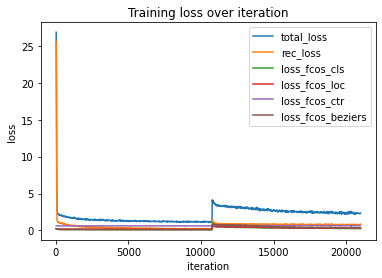

#<font size = 5><font color = pink> **Test**

Đầu tiên, download public test set mà cuộc thi cung cấp

In [ ]:
#download test set
!gdown --id 1-E8X38I_h1NxacL6O6Defl6Zd_jbw3ph -O test.zip
!unzip test.zip
!rm test.zip

Downloading...
From: https://drive.google.com/uc?id=1-E8X38I_h1NxacL6O6Defl6Zd_jbw3ph
To: /content/AdelaiDet/test.zip
320MB [00:02, 124MB/s]
Archive:  test.zip
   creating: public_test/
  inflating: public_test/test_0970.jpg  
  inflating: public_test/test_0786.jpg  
  inflating: public_test/test_0496.jpg  
  inflating: public_test/test_0678.jpg  
  inflating: public_test/test_0379.jpg  
  inflating: public_test/test_0220.jpg  
  inflating: public_test/test_0194.jpg  
  inflating: public_test/test_0835.jpg  
  inflating: public_test/test_0015.jpg  
  inflating: public_test/test_0841.jpg  
  inflating: public_test/test_0486.jpg  
  inflating: public_test/test_0780.jpg  
  inflating: public_test/test_0602.jpg  
  inflating: public_test/test_0620.jpg  
  inflating: public_test/test_0514.jpg  
  inflating: public_test/test_0779.jpg  
  inflating: public_test/test_0850.jpg  
  inflating: public_test/test_0949.jpg  
  inflating: public_test/test_0470.jpg  
  inflating: public_test/test_0187.

Tiếp theo, tạo thư mục để lưu trữ các kết quả dự đoán của mô hình.

In [ ]:
#create directory for storing prediction data
!mkdir output

Tiếp theo, download mô hình mà nhóm đã huấn luyện

In [ ]:
#download trained model
!gdown --id 1WlWyYIY1HvMcSZdlhbQS0W90yabvNJBB -O model.pth

Downloading...
From: https://drive.google.com/uc?id=1WlWyYIY1HvMcSZdlhbQS0W90yabvNJBB
To: /content/training_dir/model.pth
295MB [00:01, 153MB/s]


Tiếp theo, thực hiện dự đoán bằng câu lệnh sau với các thông số:```--input``` - thư mục chứa các ảnh cần dự đoán, ```--output``` - thư mục chứa kết quả dự đoán của mô hình và ```MODEL.WEIGHTS``` - file chứa mô hình. Có thể thay đổi các thông số này cho phù hợp. Kết quả của quá trình này là một file ```results.txt``` chứa kết quả dự đoán của mô hình theo format submission của cuộc thi và những file ```.jpg``` là các ảnh visualize kết quả dự đoán của mô hình.

In [ ]:
!python demo/demo.py \
    --config-file configs/BAText/CustomText/attn_R_50.yaml \
    --input public_test/ \
    --output output/ \
    --opts MODEL.WEIGHTS model.pth

[08/13 12:52:22 detectron2]: Arguments: Namespace(confidence_threshold=0.3, config_file='configs/BAText/TotalText/attn_R_50.yaml', input=['public_test/'], opts=['MODEL.WEIGHTS', 'model.pth'], output='output/', video_input=None, webcam=False)
WARNING [08/13 12:52:22 d2.config.compat]: Config 'configs/BAText/TotalText/attn_R_50.yaml' has no VERSION. Assuming it to be compatible with latest v2.
  0% 0/987 [00:00<?, ?it/s]/content/AdelaiDet/adet/modeling/batext/batext_outputs.py:469: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  per_candidate_nonzeros = per_candidate_inds.nonzero()
[08/13 12:52:27 detectron2]: public_test/test_0001.jpg: detected 13 instances in 0.40s
  0% 1/987 [00:00<08:44,  1.88it/s][08/13 12:52:27 detectron2]: public_test/test_0002.jpg: detected 13 instances in 0.23s
  0% 2/987 [00:00<07:27

#<font size = 5><font color = pink> **Phụ lục: Giải thích file json**

Trong file json có hai key quan trọng đó là ```"images"``` dùng để lưu thông tin về ảnh và ```"annotations"``` dùng để lưu thông tin về nhãn.

Mỗi phần tử trong ```"images"``` tượng trưng cho một ảnh. Key ```"images"``` có các thông tin cần chú ý như sau:
* ```"file_name"```: tên file ảnh
* ```"id"```: id của ảnh, ở đây nhóm lấy id của ảnh trùng với 4 chữ số cuối của file ảnh
* ```"width"```: chiều rộng ảnh
* ```"height"```: chiều cao ảnh

Mỗi phần tử trong ```"annotations"``` tượng trưng cho một nhãn text. Key ```"annotations"``` có các thông tin cần chú ý như sau:
* ```"bbox"```: lưu thông tin ```[xmin, ymin, width, height]``` của bounding box của nhãn
* ```"id"```: id của nhãn
* ```"image_id"```: id của ảnh
* ```"bezier_pts"```: 8 điểm control point của bezier bounding box
* ```"rec"```: nội dung của text. Được lưu dưới dạng thứ tự (index) của từng ký tự trong nhãn so với ```CTLabels```. ```"rec"``` có độ dài tối đa là 100 ký tự.